<span style='font-size:xx-large'>**SC1015 Project**</span>  



In [138]:
# Import essential libraries and csv file used for exploratory data analysis:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

sb.set() # set the default Seaborn style for graphics

# for tree visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [102]:
medIn = pd.read_csv("medical_insurance.csv")
medIn.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [103]:
# Check statistics of the dataset using the type and shape attributes:

print("Data type : ", type(medIn))
print("Data dims : ", medIn.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (2772, 7)


In [37]:
# Check the variables (and their types) in the dataset using the dtypes attribute:

print(medIn.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [104]:
# Separating numeric data from original data:

intandfloat = medIn.select_dtypes(include = ['int64', 'float64'])

In [105]:
# Obtaining correlation between numeric data before cleaning:

intandfloat.corr()

,age,bmi,children,charges
age,1.000000,0.113048,0.037574,0.298624
bmi,0.113048,1.000000,-0.001492,0.199846
children,0.037574,-0.001492,1.000000,0.066442
charges,0.298624,0.199846,0.066442,1.000000


### **Data Cleaning**



In [106]:
medIn.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No null values.

We proceed to remove outliers in 'charges' (abnormally high or abnormally low) so as to have a better prediction.

In [107]:
medIn['charges'].describe()

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64

In [108]:
Q1 = medIn['charges'].quantile(0.25)
Q3 = medIn['charges'].quantile(0.75)
IQR = Q3 - Q1
print("Outliers:", ((medIn['charges'] < (Q1 - 1.5 * IQR)) | (medIn['charges'] > (Q3 + 1.5 * IQR))).sum(), "Skewness:", medIn['charges'].skew().round(2))
print("Data dims: ", medIn.shape)

Outliers: 296 Skewness: 1.51
Data dims:  (2772, 7)


In [109]:
medIn_cleaned = medIn.copy()

lowerBound = Q1 - 1.5*IQR
upperBound = Q3 + 1.5*IQR
upper_array = np.where(medIn_cleaned['charges'] >= upperBound)[0]
lower_array = np.where(medIn_cleaned['charges'] <= lowerBound)[0]
 
medIn_cleaned.drop(index=upper_array, inplace=True)
medIn_cleaned.drop(index=lower_array, inplace=True)

print("Outliers:", ((medIn_cleaned['charges'] < (Q1 - 1.5 * IQR))| (medIn_cleaned['charges'] > (Q3 + 1.5 * IQR))).sum(), "Skewness:", medIn_cleaned['charges'].skew().round(2))
print("Data dims for cleaned data: ", medIn_cleaned.shape)

Outliers: 0 Skewness: 1.17
Data dims for cleaned data:  (2476, 7)


### **Exploratory Data Analysis**



In [110]:
medIn_cleaned.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [111]:
print("Data dims for cleaned data: ", medIn_cleaned.shape)

Data dims for cleaned data:  (2476, 7)


<span style='font-size:large'>**Looking at numeric data:**</span>


In [112]:
# Summary Statistics for all numeric variables
intandfloat_cleaned = medIn_cleaned.select_dtypes(include = ['int64', 'float64'])
intandfloat_cleaned.describe().round(2)

,age,bmi,children,charges
count,2476.00,2476.00,2476.00,2476.00
mean,38.92,30.12,1.09,9830.52
std,14.09,6.05,1.23,7165.08
min,18.00,15.96,0.00,1121.87
25%,26.00,25.80,0.00,4349.46
50%,39.00,29.74,1.00,8338.75
75%,51.00,33.92,2.00,12829.46
max,64.00,53.13,5.00,34303.17


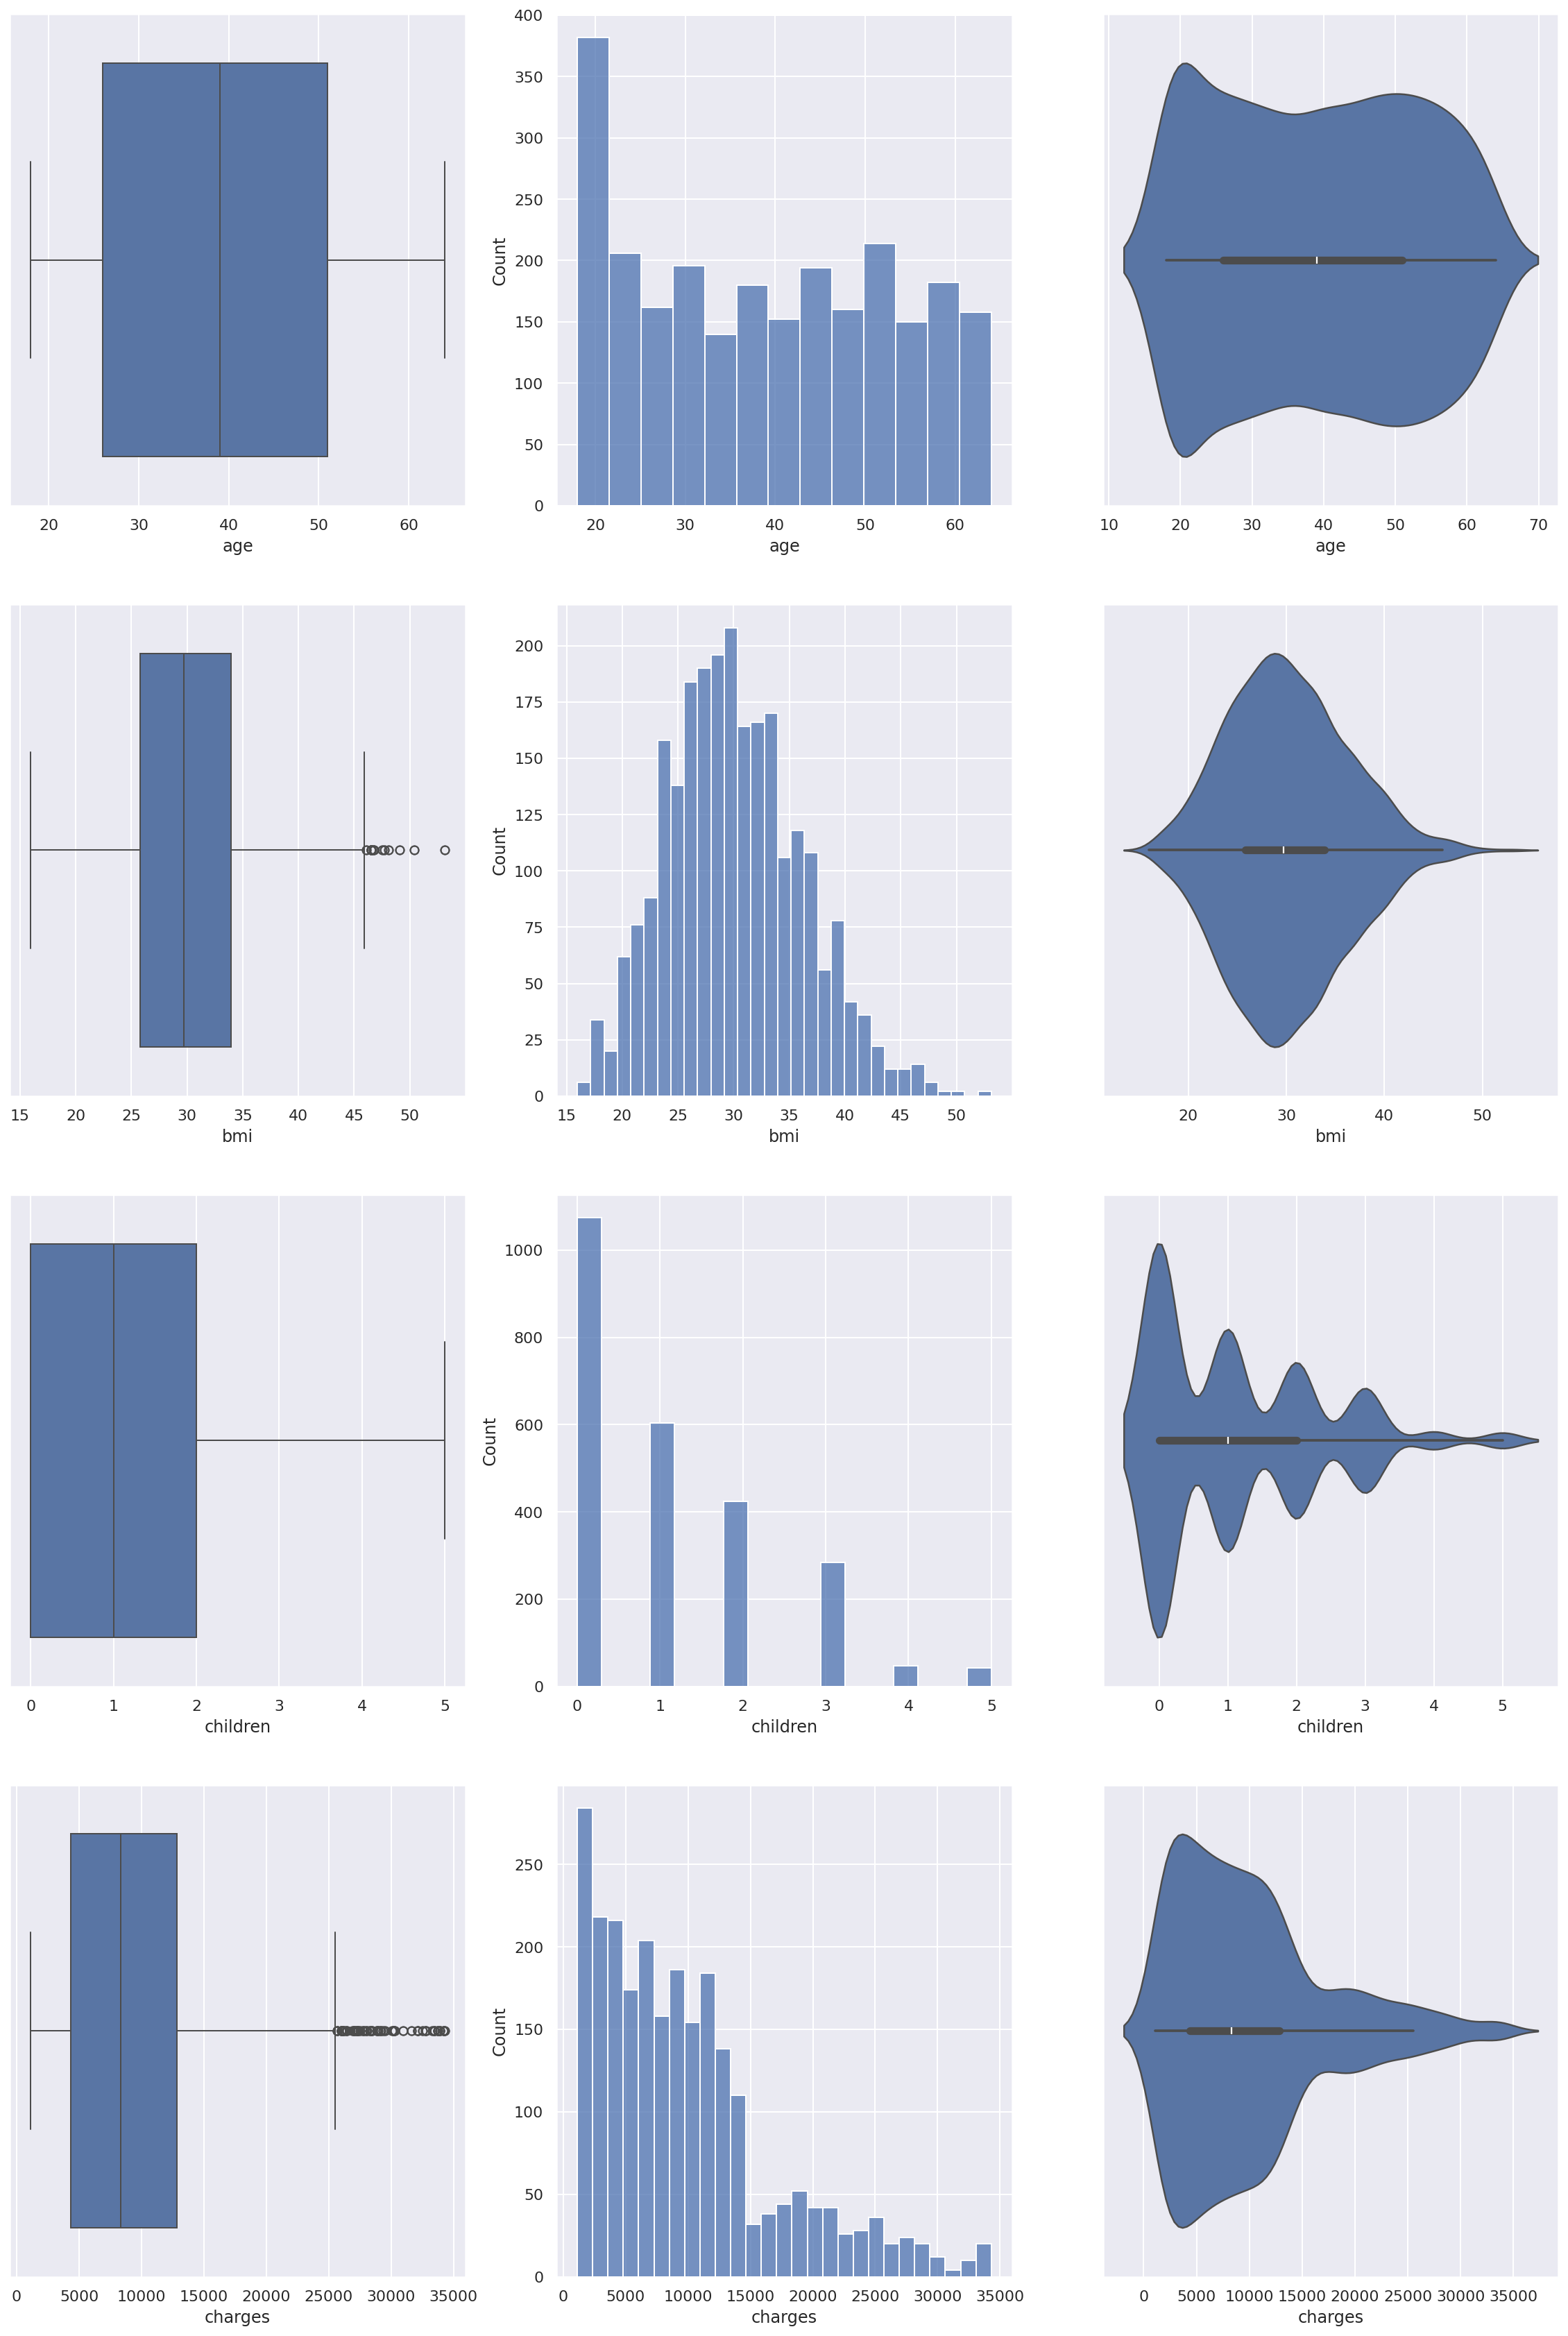

In [81]:
# Draw the distributions of all numeric variables
f, axes = plt.subplots(4, 3, figsize=(20, 30))

count = 0
for var in intandfloat_cleaned:
    sb.boxplot(data = intandfloat_cleaned[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = intandfloat_cleaned[var], ax = axes[count,1])
    sb.violinplot(data = intandfloat_cleaned[var], orient = "h", ax = axes[count,2])
    count += 1

In [113]:
intandfloat_cleaned.corr()

,age,bmi,children,charges
age,1.000000,0.123275,0.032264,0.449008
bmi,0.123275,1.000000,-0.011310,-0.071308
children,0.032264,-0.011310,1.000000,0.087210
charges,0.449008,-0.071308,0.087210,1.000000


<Axes: >

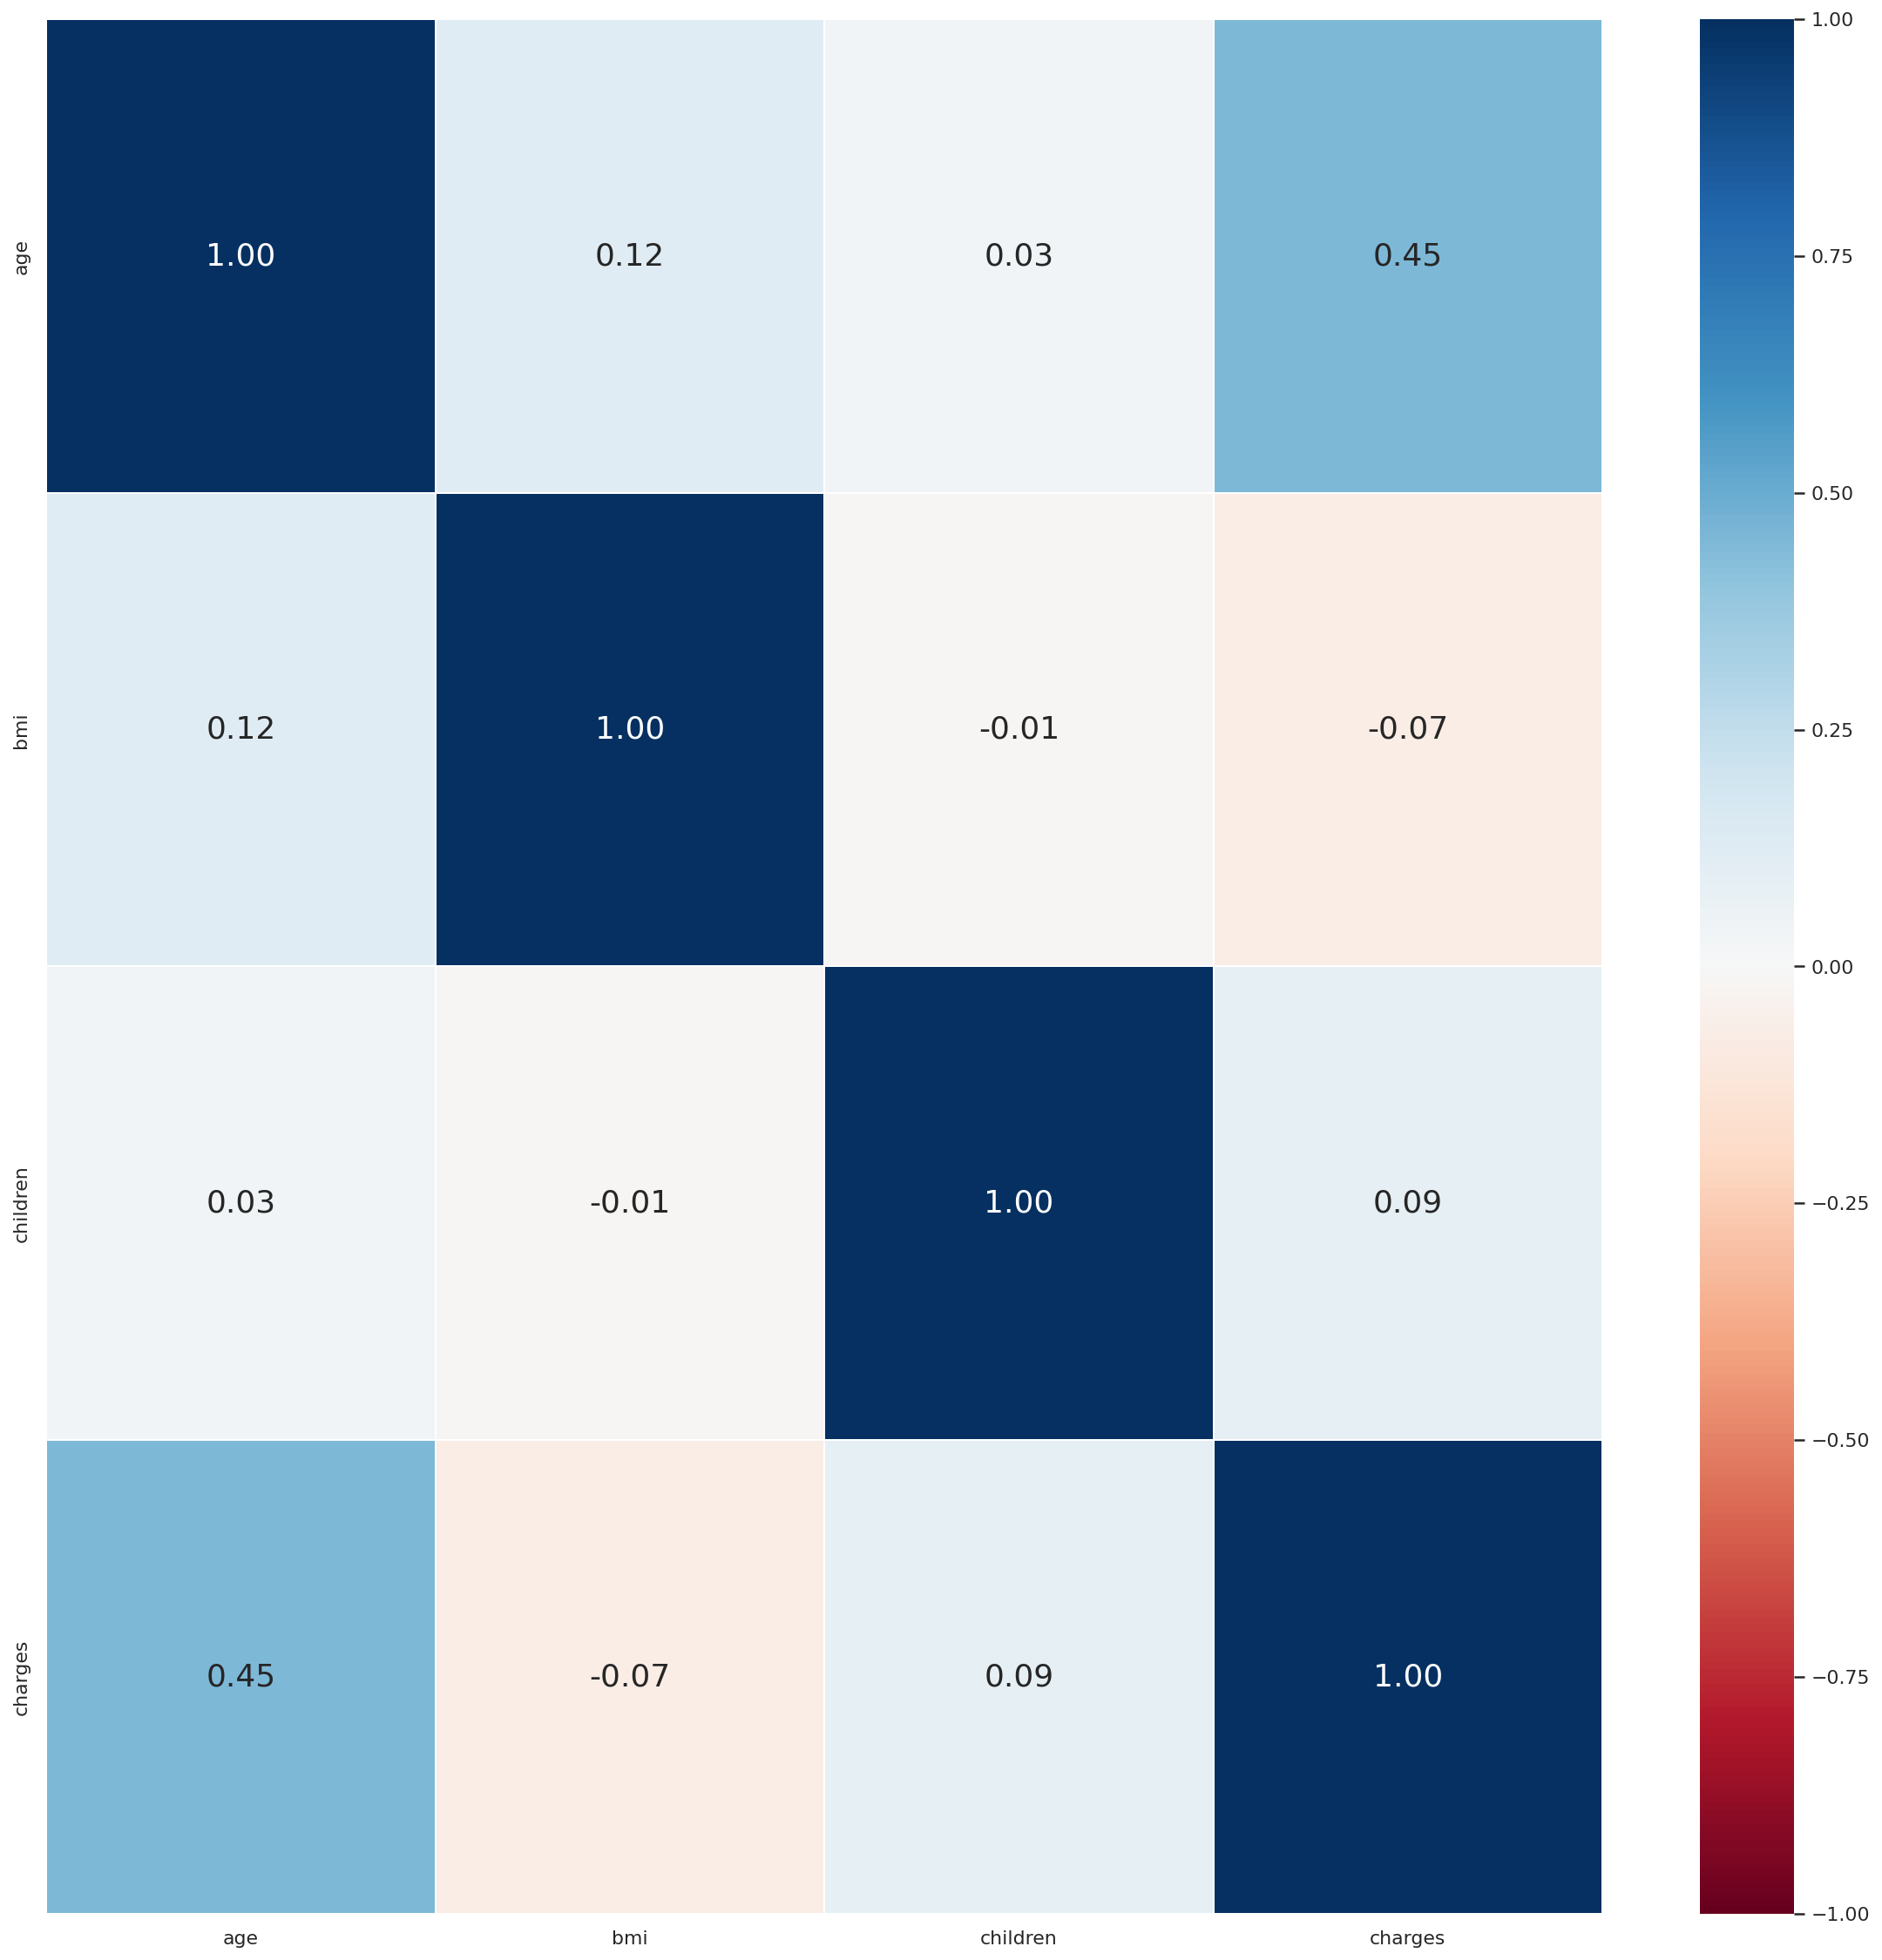

In [83]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sb.heatmap(intandfloat_cleaned.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We observe the highest correlation between charges and age, at 0.45 \(moderate positive correlation\).  



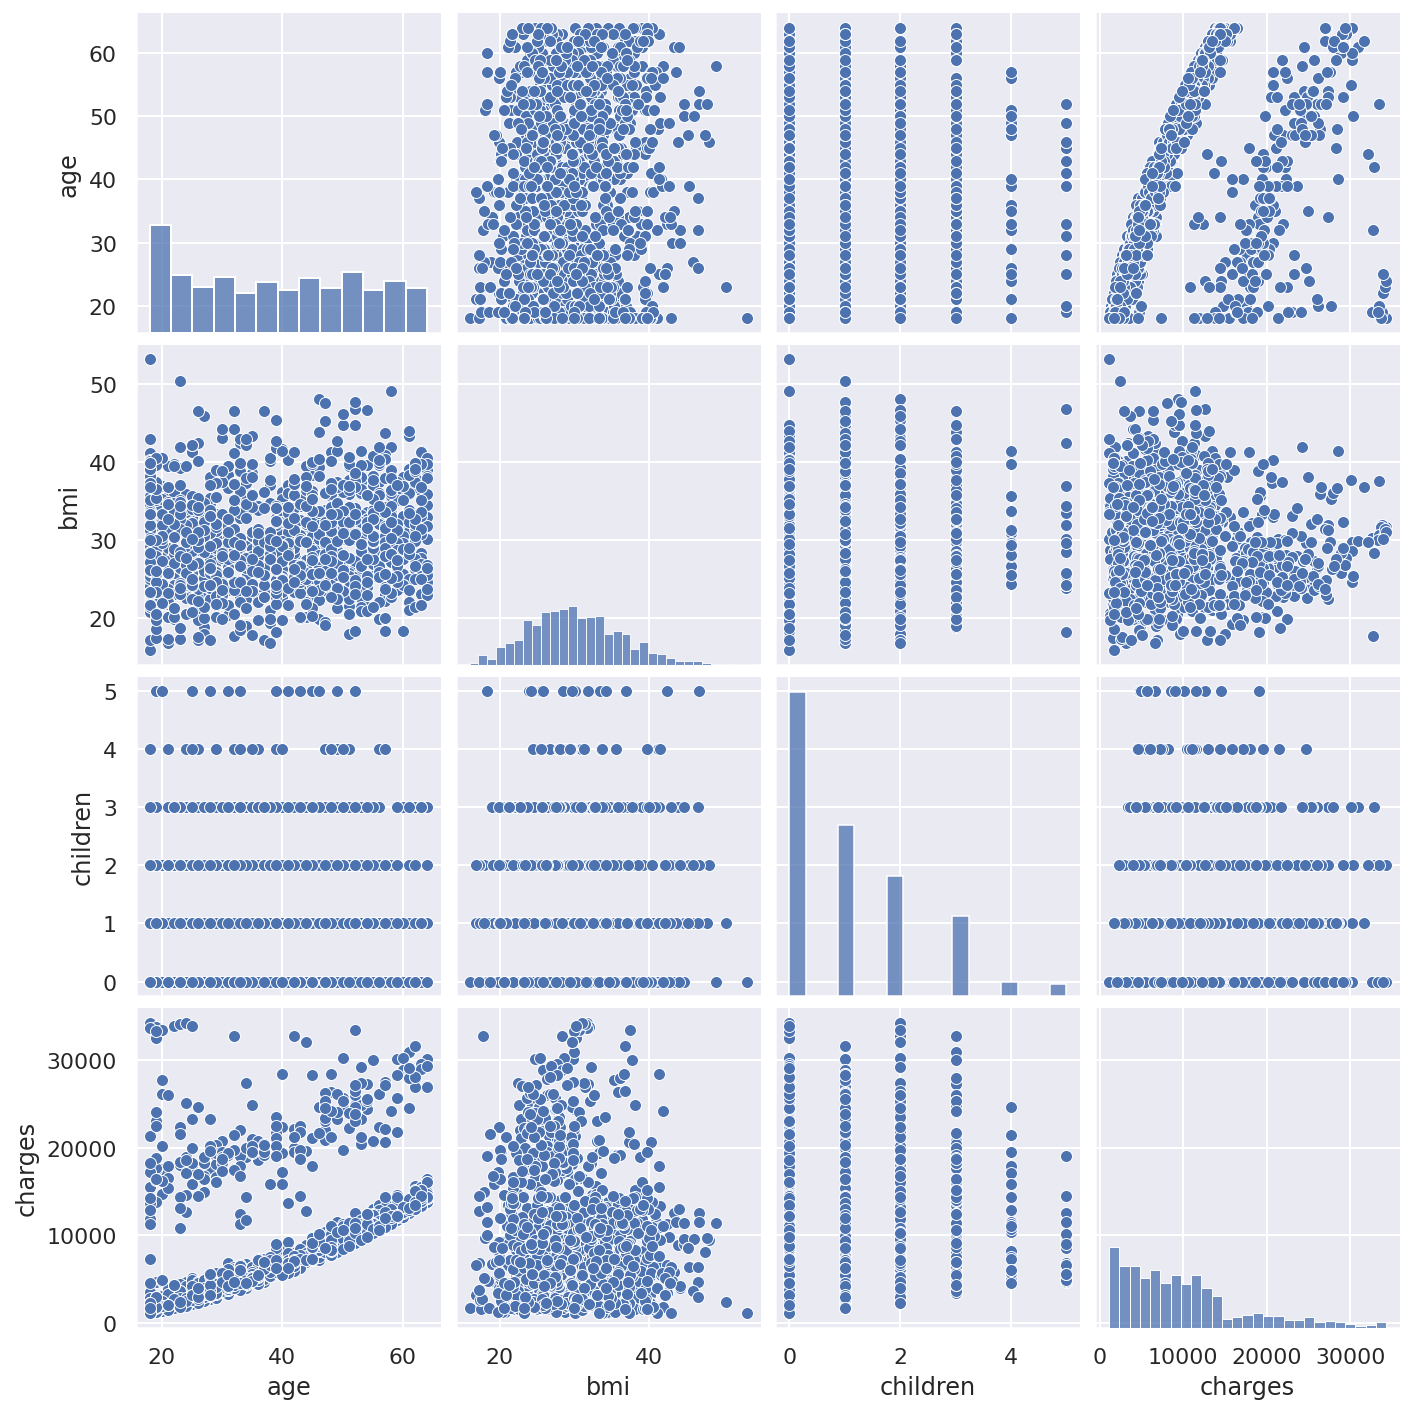

In [84]:
# Draw pairs of variables against one another
sb.pairplot(data = intandfloat_cleaned)

<span style='font-size:large'>**Looking at categorical data:**</span>  



In [114]:
medIn_cleaned['sex'].value_counts()

sex
female    1262
male      1214
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='charges'>

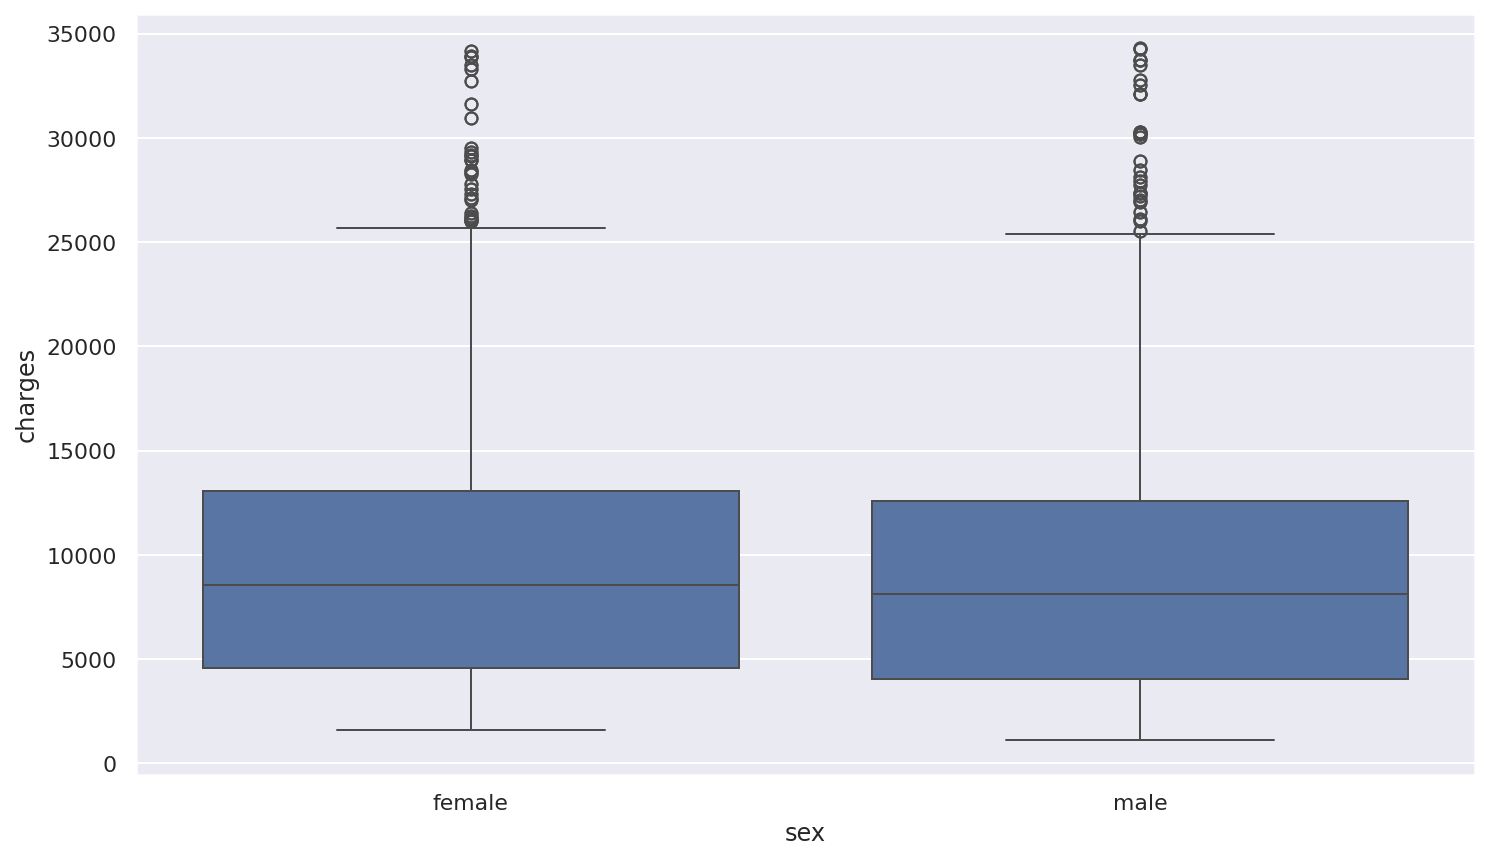

In [86]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['sex'])

In [115]:
medIn_cleaned['smoker'].value_counts()

smoker
no     2202
yes     274
Name: count, dtype: int64

<Axes: xlabel='smoker', ylabel='charges'>

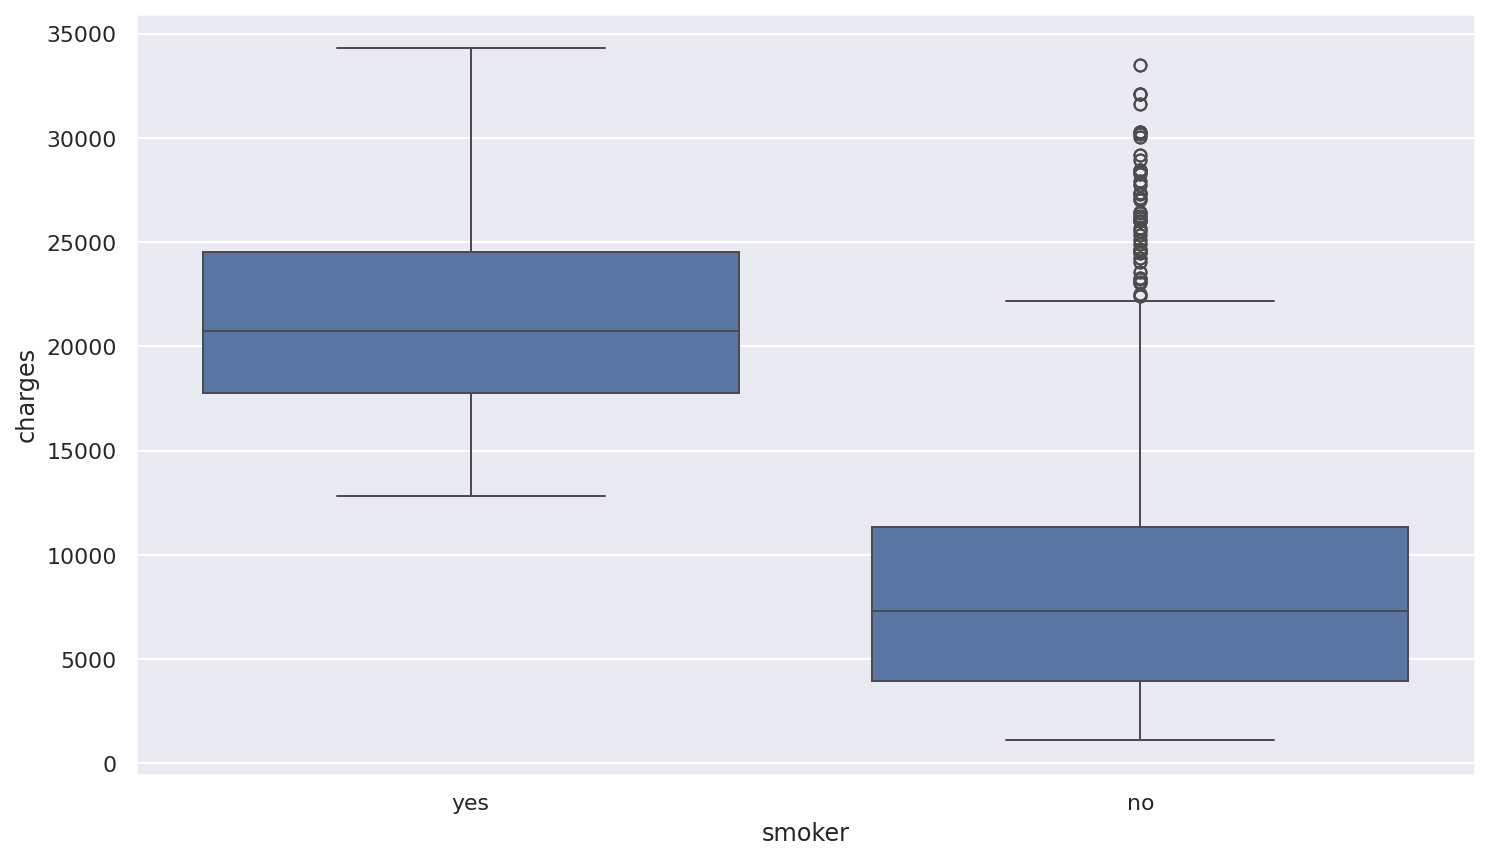

In [88]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['smoker'])

In [116]:
print(medIn_cleaned.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In general, we observe that smokers incur higher medical insurance charges, as seen from how the lowest charge for a smoker almost coincides with the 3rd quartile \(75th percentile\) of non\-smokers.  



In [89]:
medIn_cleaned['region'].value_counts()

region
southeast    640
northwest    624
southwest    612
northeast    600
Name: count, dtype: int64

<Axes: xlabel='region', ylabel='charges'>

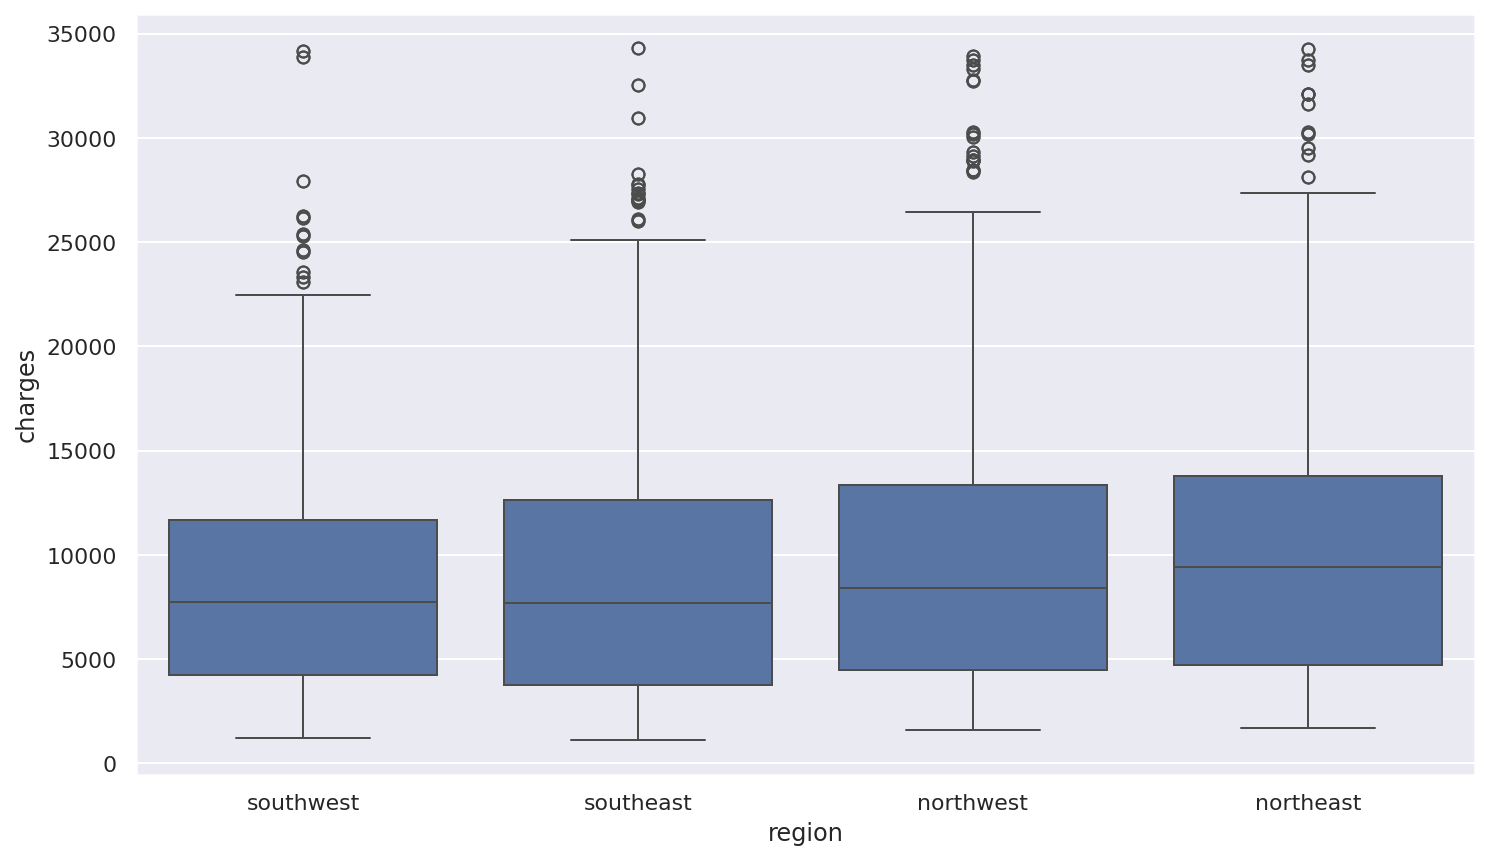

In [90]:
sb.boxplot(data=medIn_cleaned, y=medIn_cleaned['charges'], x=medIn_cleaned['region'])

In [122]:
medIn_cleaned_copy = medIn_cleaned.copy()

# Mapping 'yes' to 1 and 'no' to 0 for 'smoker' column, and changing data type to boolean
medIn_cleaned_copy['smoker'] = (medIn_cleaned_copy['smoker'] == 'yes').astype(bool)

# Mapping 'female' to 1 and 'male' to 0 for 'sex' column, and changing data type to boolean
medIn_cleaned_copy['sex'] = (medIn_cleaned_copy['sex'] == 'female').astype(bool)

print(medIn_cleaned_copy.head())


   age    sex     bmi  children  smoker     region      charges
0   19   True  27.900         0    True  southwest  16884.92400
1   18  False  33.770         1   False  southeast   1725.55230
2   28  False  33.000         3   False  southeast   4449.46200
3   33  False  22.705         0   False  northwest  21984.47061
4   32  False  28.880         0   False  northwest   3866.85520


### Linear Regression

In [91]:
# With seed
seed_value = 42
np.random.seed(seed_value)

X = pd.DataFrame(medIn_cleaned[['age', 'bmi']])
y = pd.DataFrame(medIn_cleaned['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [126]:
# Visualize the distribution of the target variable

<Axes: >

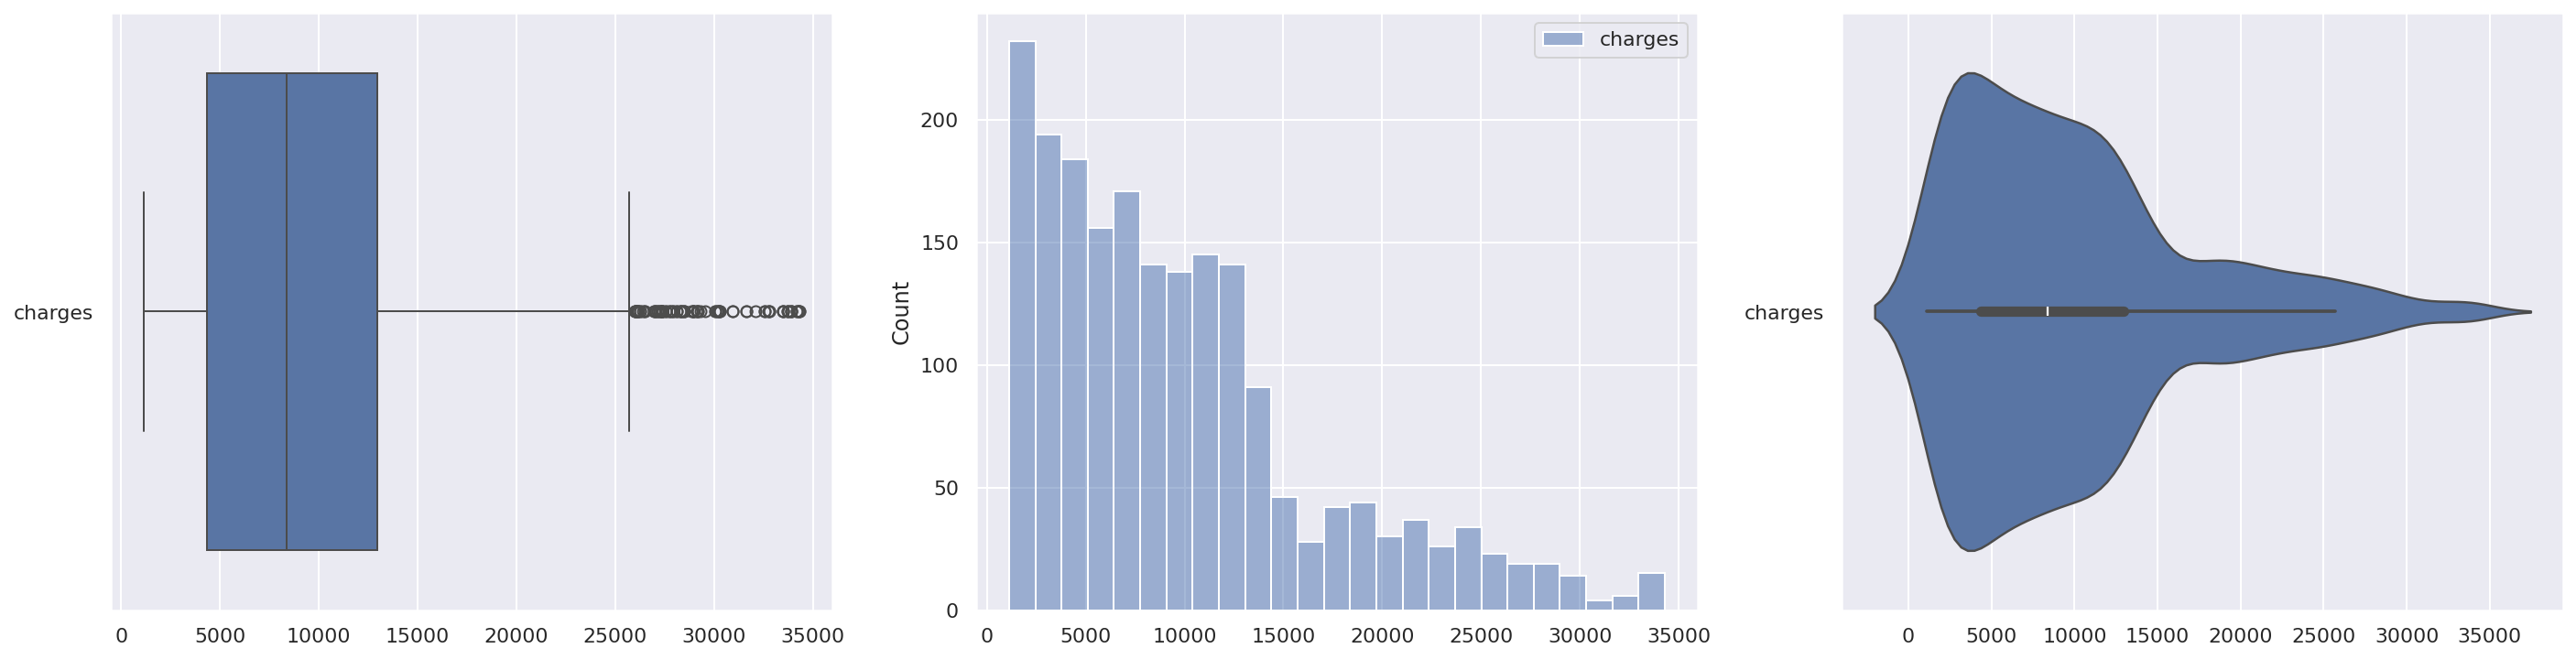

In [92]:
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_train, orient = "h", ax = axes[0])
sb.histplot(data = y_train, ax = axes[1])
sb.violinplot(data = y_train, orient = "h", ax = axes[2])

In [127]:
# Visualize the distribution of the predictor variables

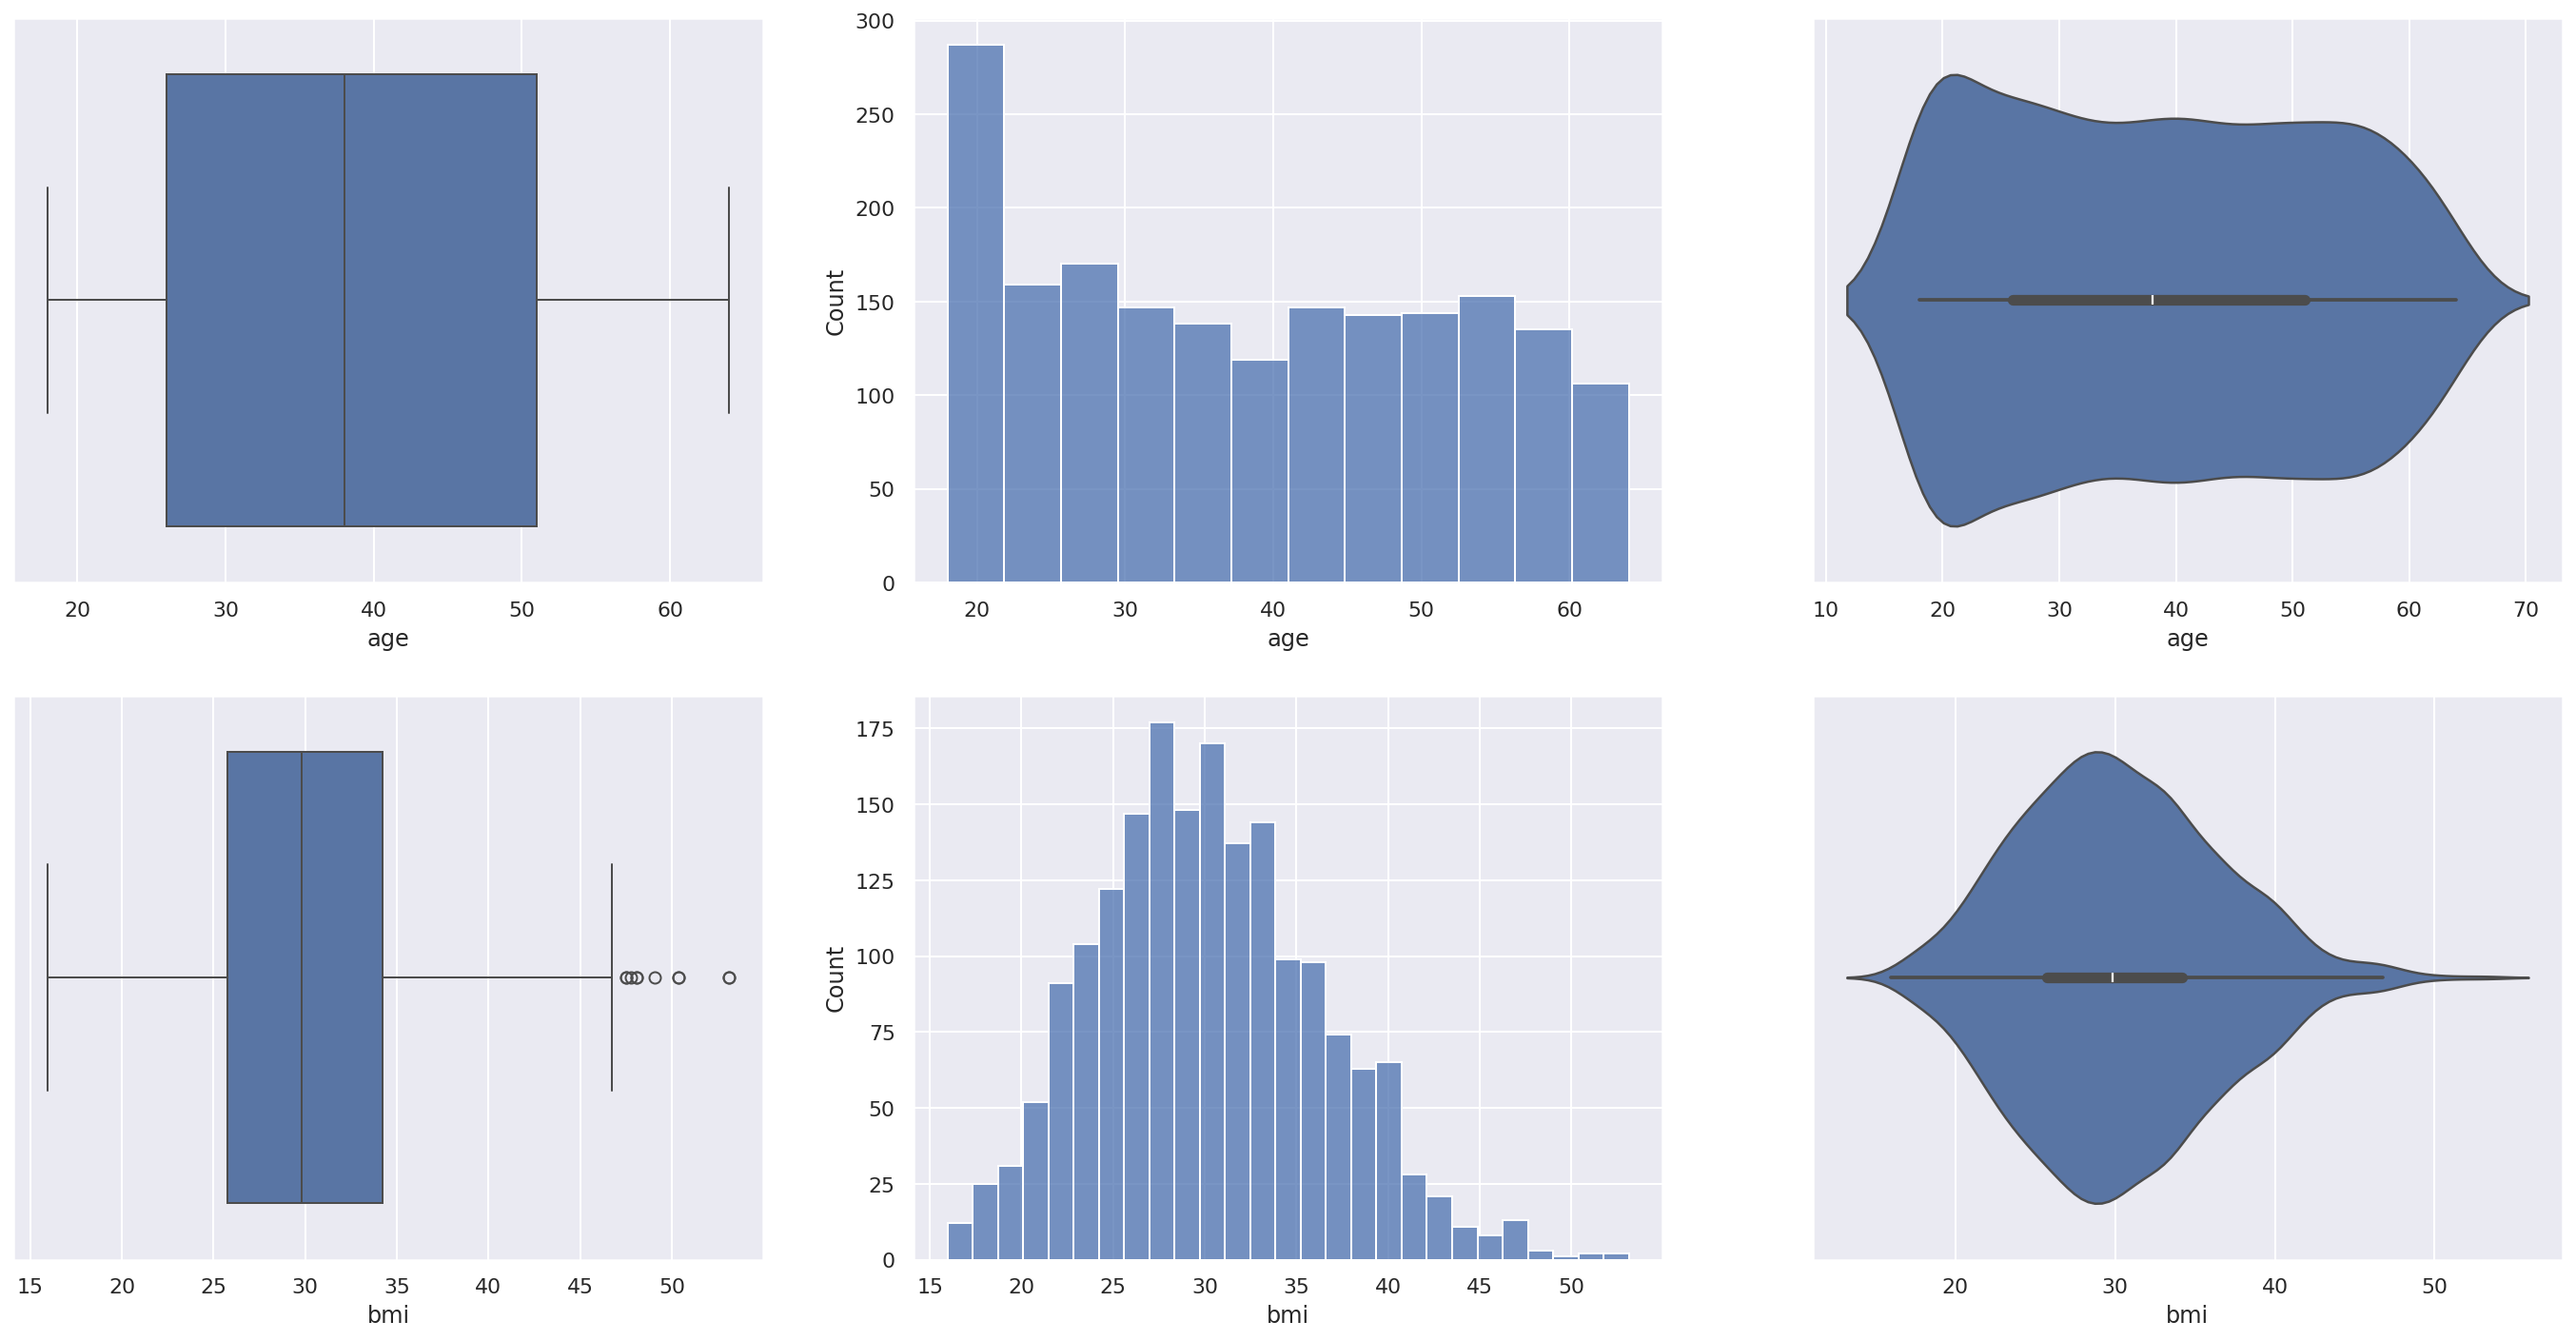

In [157]:
f, axes = plt.subplots(2, 3, figsize=(24, 12))

count = 0
for var in X_train:
    sb.boxplot(data = X_train[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_train[var], ax = axes[count,1])
    sb.violinplot(data = X_train[var], orient = "h", ax = axes[count,2])
    count += 1

<Axes: >

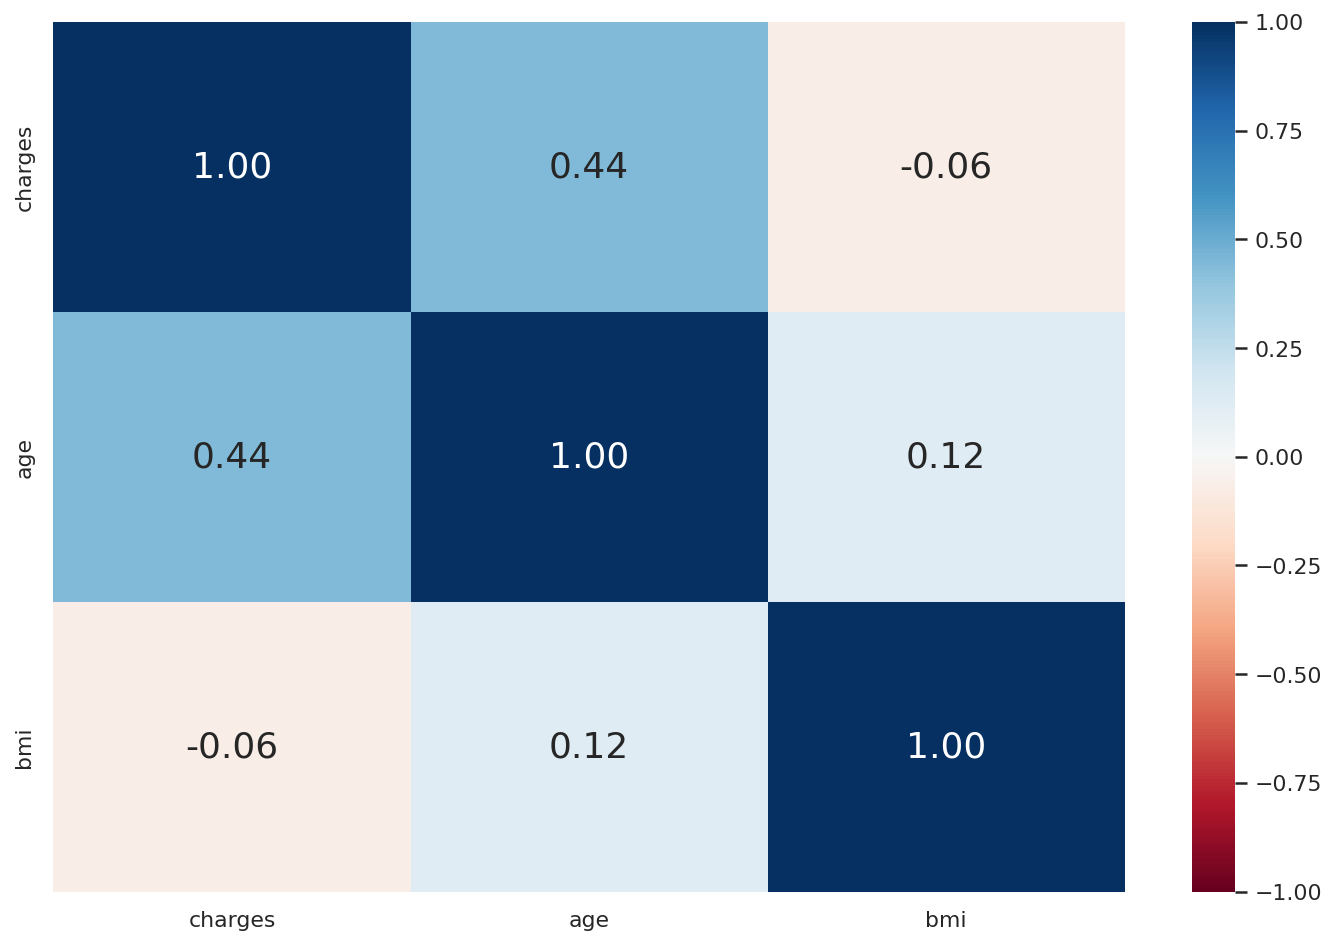

In [123]:
# Correlation between Response and the Predictors
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f",
           annot_kws = {"size" : 18}, cmap = "RdBu")

<span style='font-size:medium'>The highest correlation was observed between age and charges, at 0.44 \(moderately positive correlation\).</span>  



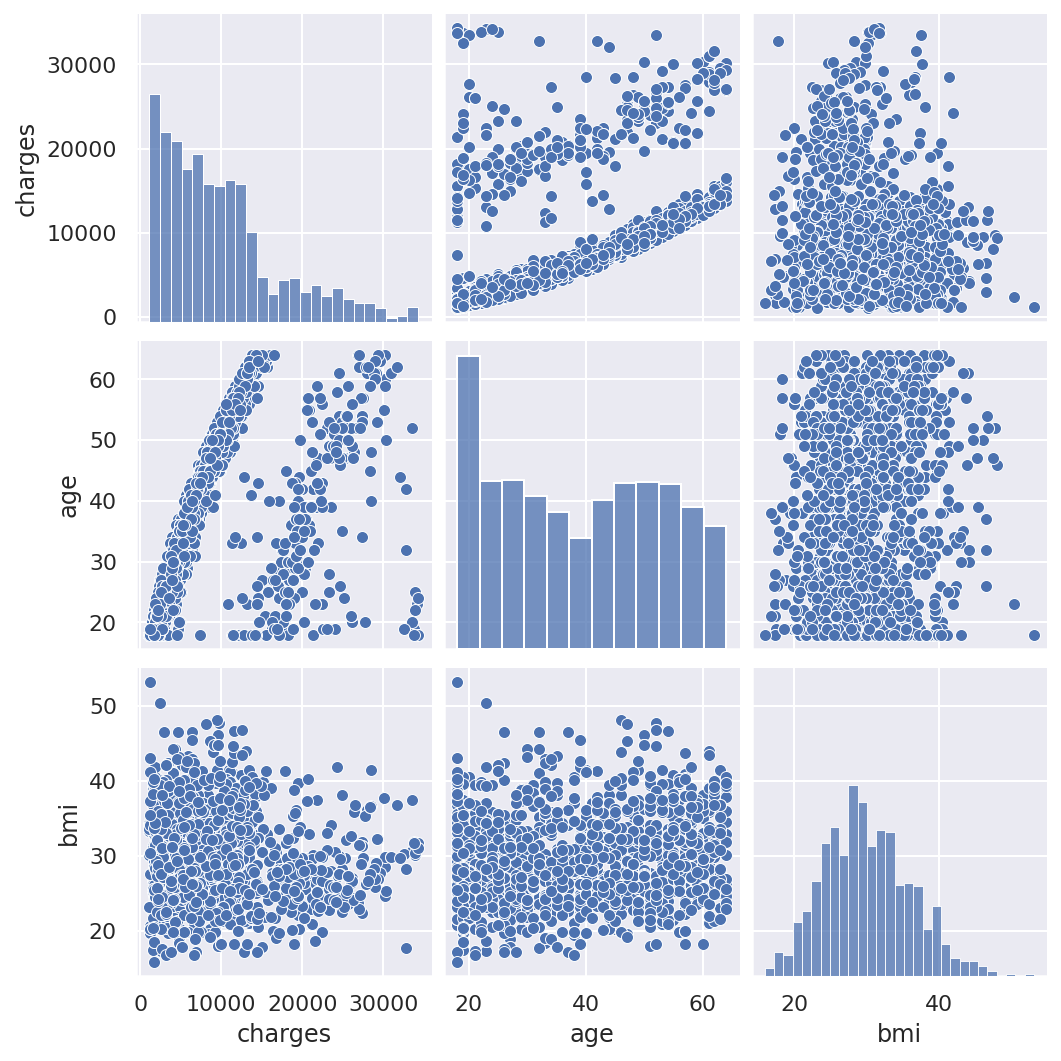

In [94]:
sb.pairplot(data = trainDF)

In [71]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [5039.76928102]
Coefficients of Regression 	: a =  [[ 234.04697972 -141.92778987]]



,Predictors,Coefficients
0,age,234.04698
1,bmi,-141.92779


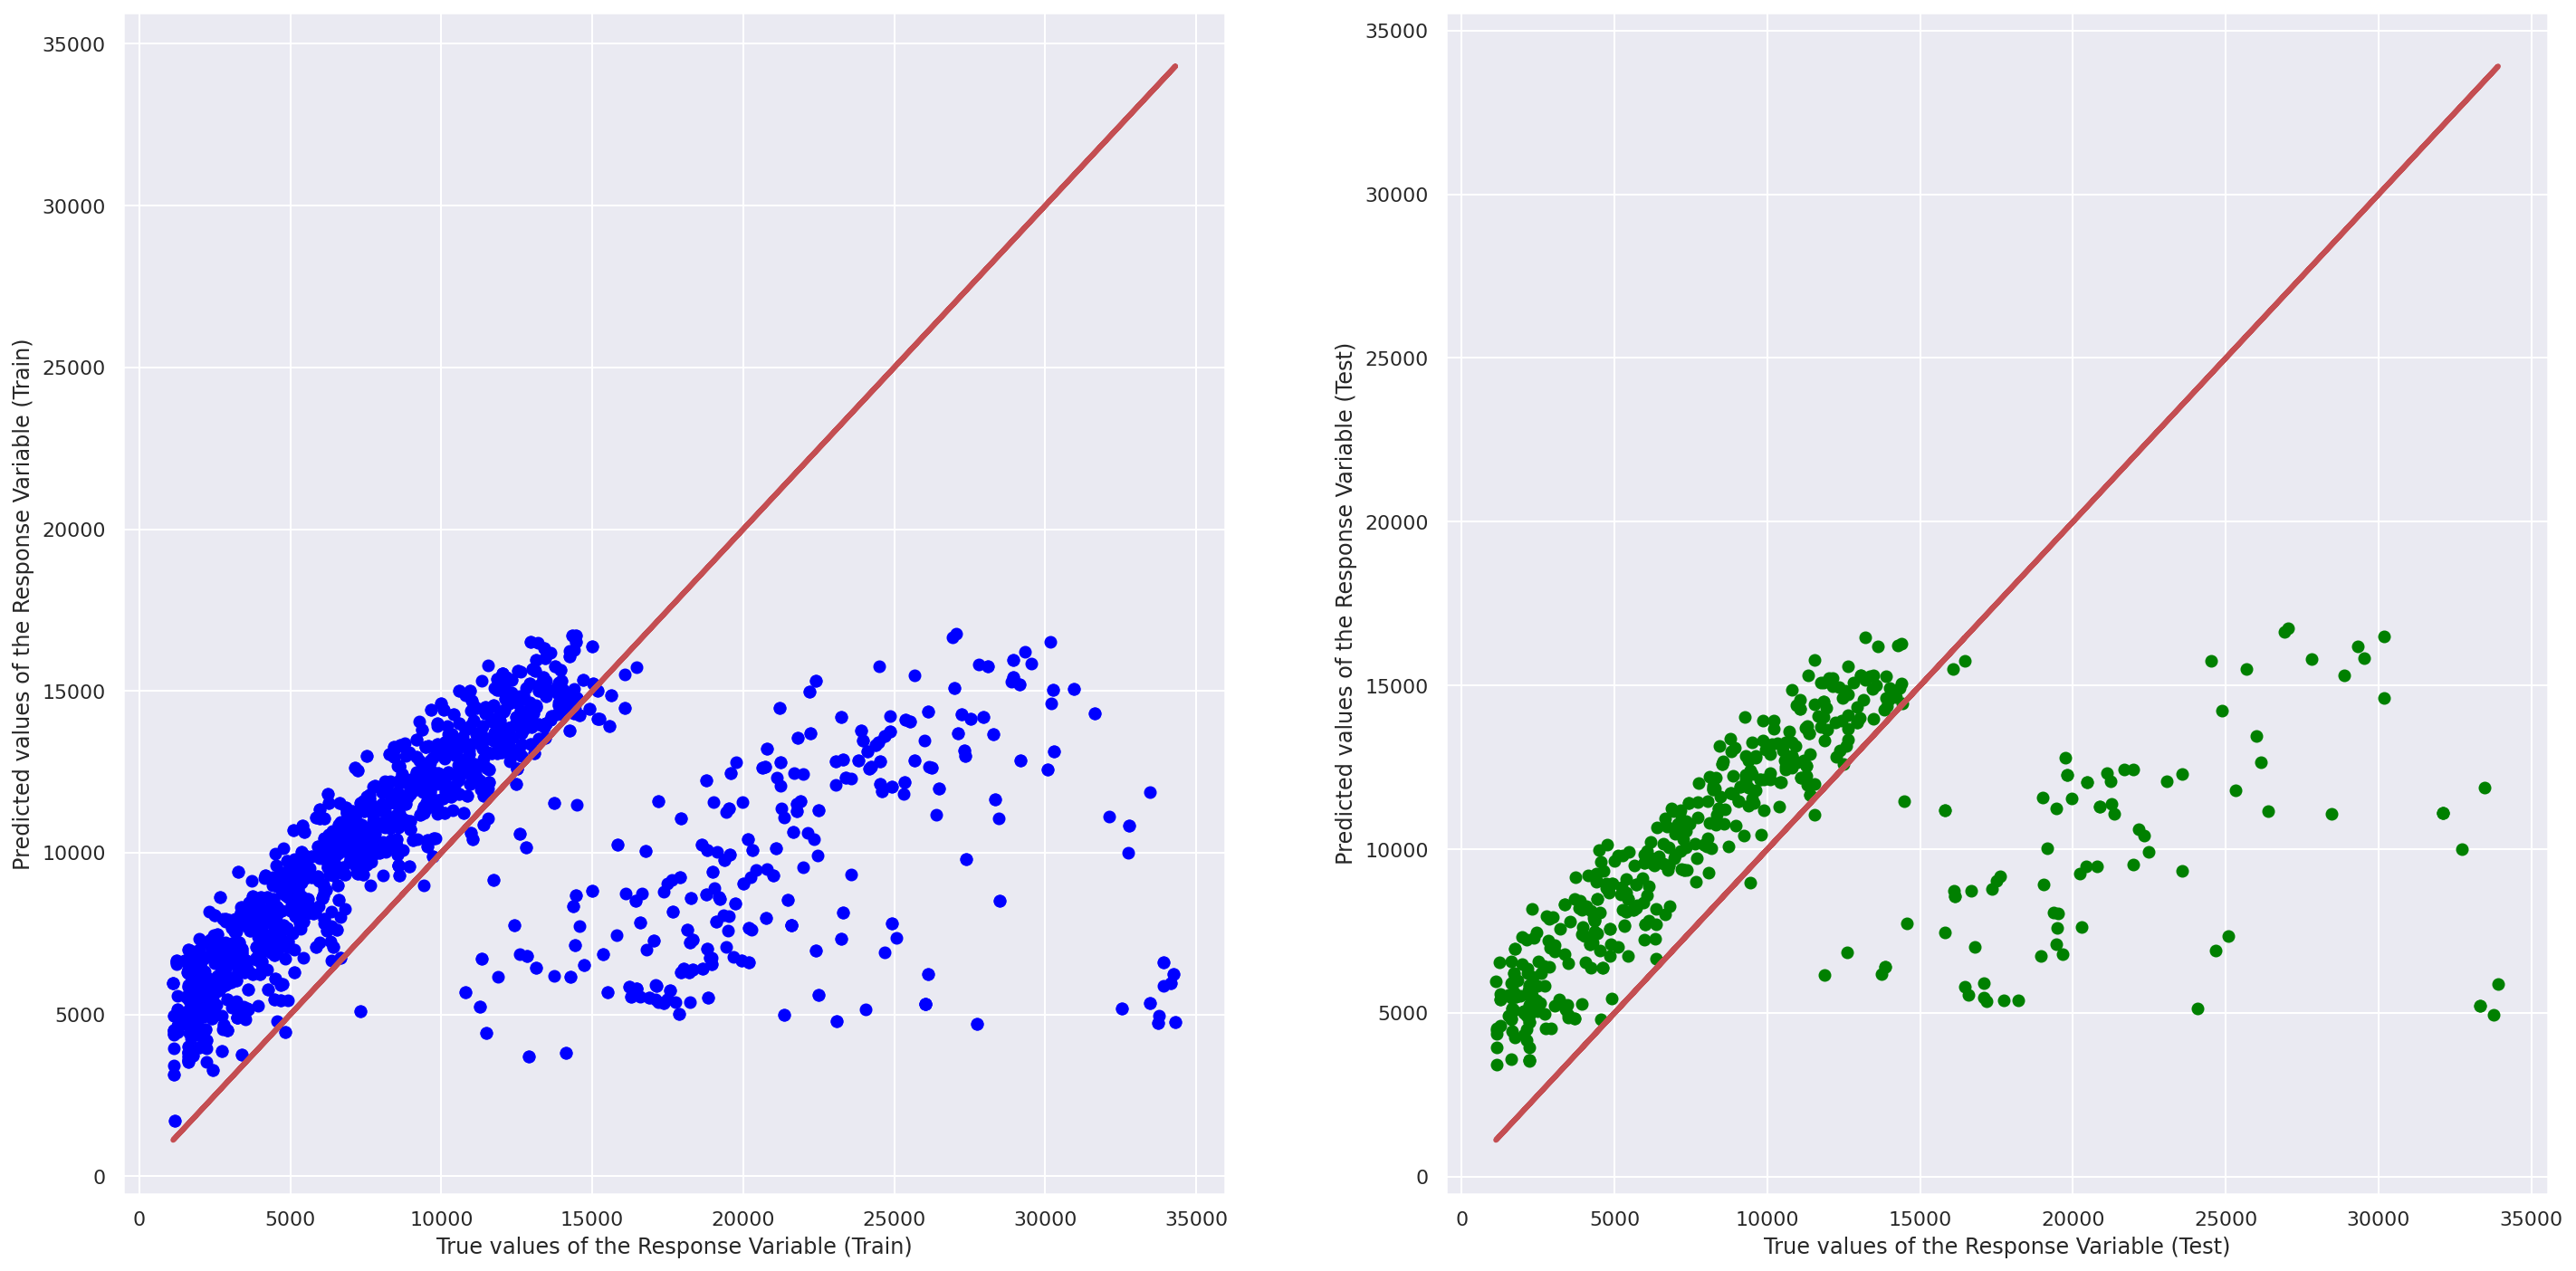

In [134]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [135]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.21123239970110874
Mean Squared Error (MSE) 	: 40712119.28406432

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.24401855573982234
Mean Squared Error (MSE) 	: 37865942.744561985



### Polynomial Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


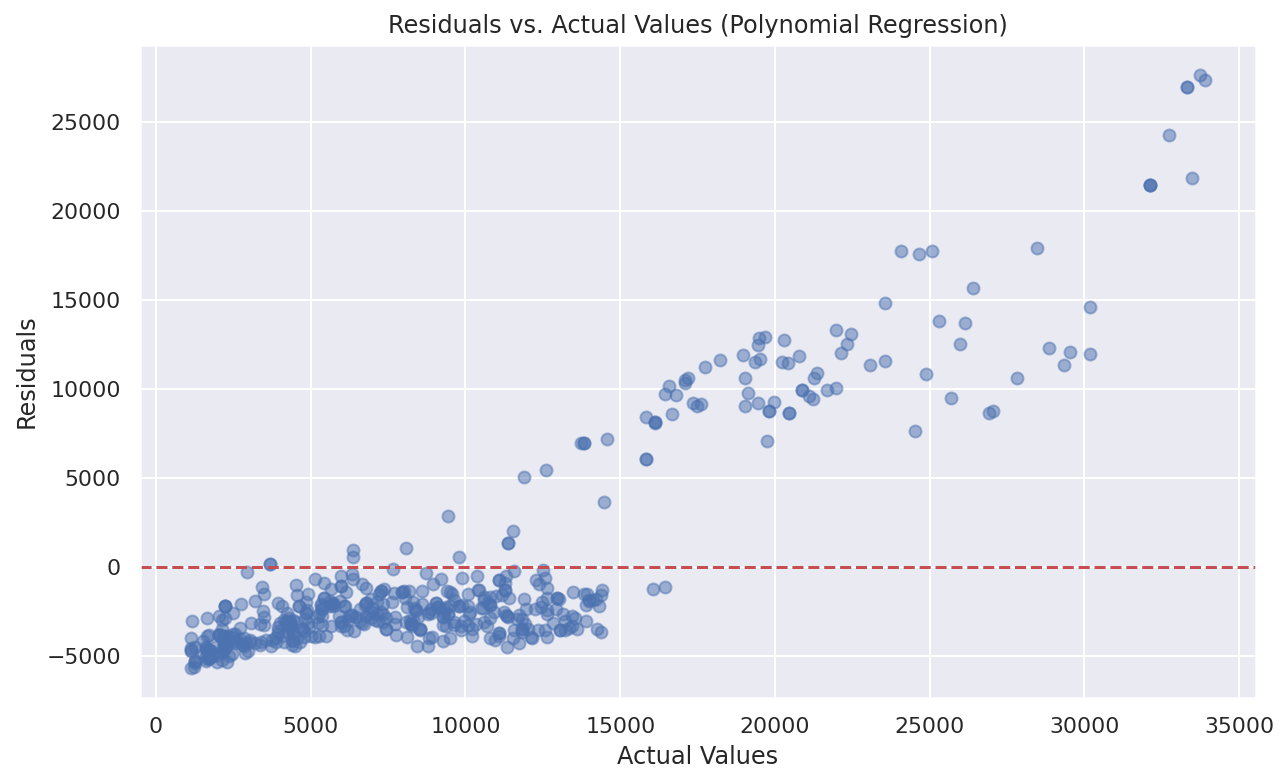

In [136]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Regularization: Ridge regression
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_model.fit(X_train, y_train)

# Regularization: Lasso regression
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
lasso_model.fit(X_train, y_train)

# Cross-validation
ridge_cv_score = ridge_model.score(X_test, y_test)
lasso_cv_score = lasso_model.score(X_test, y_test)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering: Adding polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Linear Regression with polynomial features
linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train)

# Model Evaluation
y_train_pred_poly = linreg_poly.predict(X_train_poly)
y_test_pred_poly = linreg_poly.predict(X_test_poly)
mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)
r2_train_poly = linreg_poly.score(X_train_poly, y_train)
r2_test_poly = linreg_poly.score(X_test_poly, y_test)

# Residual Analysis
residuals_poly = y_test - y_test_pred_poly

# Visualizing residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_poly, alpha=0.5)
plt.title('Residuals vs. Actual Values (Polynomial Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


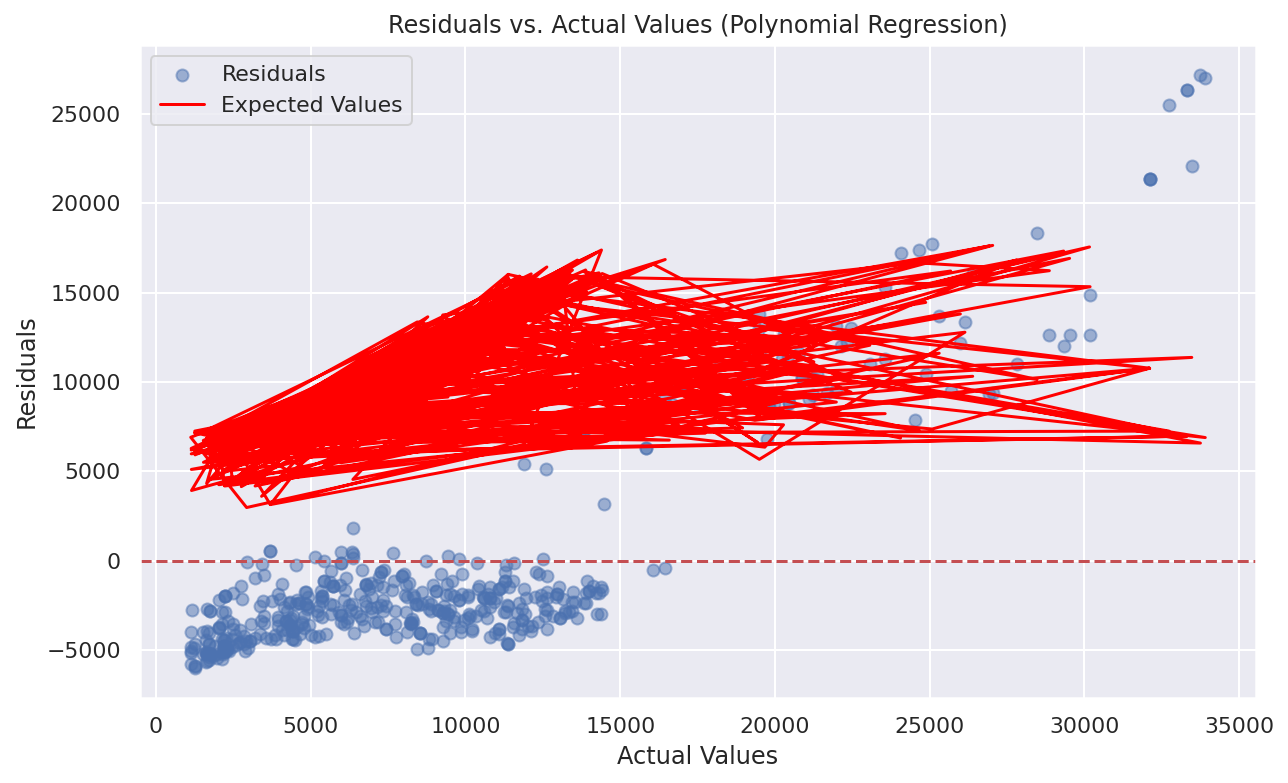

In [137]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Regularization: Ridge regression
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge_model.fit(X_train, y_train)

# Regularization: Lasso regression
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
lasso_model.fit(X_train, y_train)

# Cross-validation
ridge_cv_score = ridge_model.score(X_test, y_test)
lasso_cv_score = lasso_model.score(X_test, y_test)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering: Adding polynomial features
from sklearn.preprocessing import PolynomialFeatures

# Change the order of polynomial features here (e.g., degree=3 for third-order polynomial)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Linear Regression with polynomial features
linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train)

# Model Evaluation
y_train_pred_poly = linreg_poly.predict(X_train_poly)
y_test_pred_poly = linreg_poly.predict(X_test_poly)
mse_train_poly = mean_squared_error(y_train, y_train_pred_poly)
mse_test_poly = mean_squared_error(y_test, y_test_pred_poly)
r2_train_poly = linreg_poly.score(X_train_poly, y_train)
r2_test_poly = linreg_poly.score(X_test_poly, y_test)

# Residual Analysis
residuals_poly = y_test - y_test_pred_poly

# Calculate the expected graph line
expected_values = linreg_poly.predict(X_test_poly)

# Visualizing residuals and expected graph line
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_poly, alpha=0.5, label='Residuals')
plt.plot(y_test, expected_values, color='red', label='Expected Values')
plt.title('Residuals vs. Actual Values (Polynomial Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()


### Random Forest Regression


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train MSE: 3315514.9317587274
Test MSE: 23413394.0423065
Train R^2: 0.93576431778873
Test R^2: 0.5325590712863617


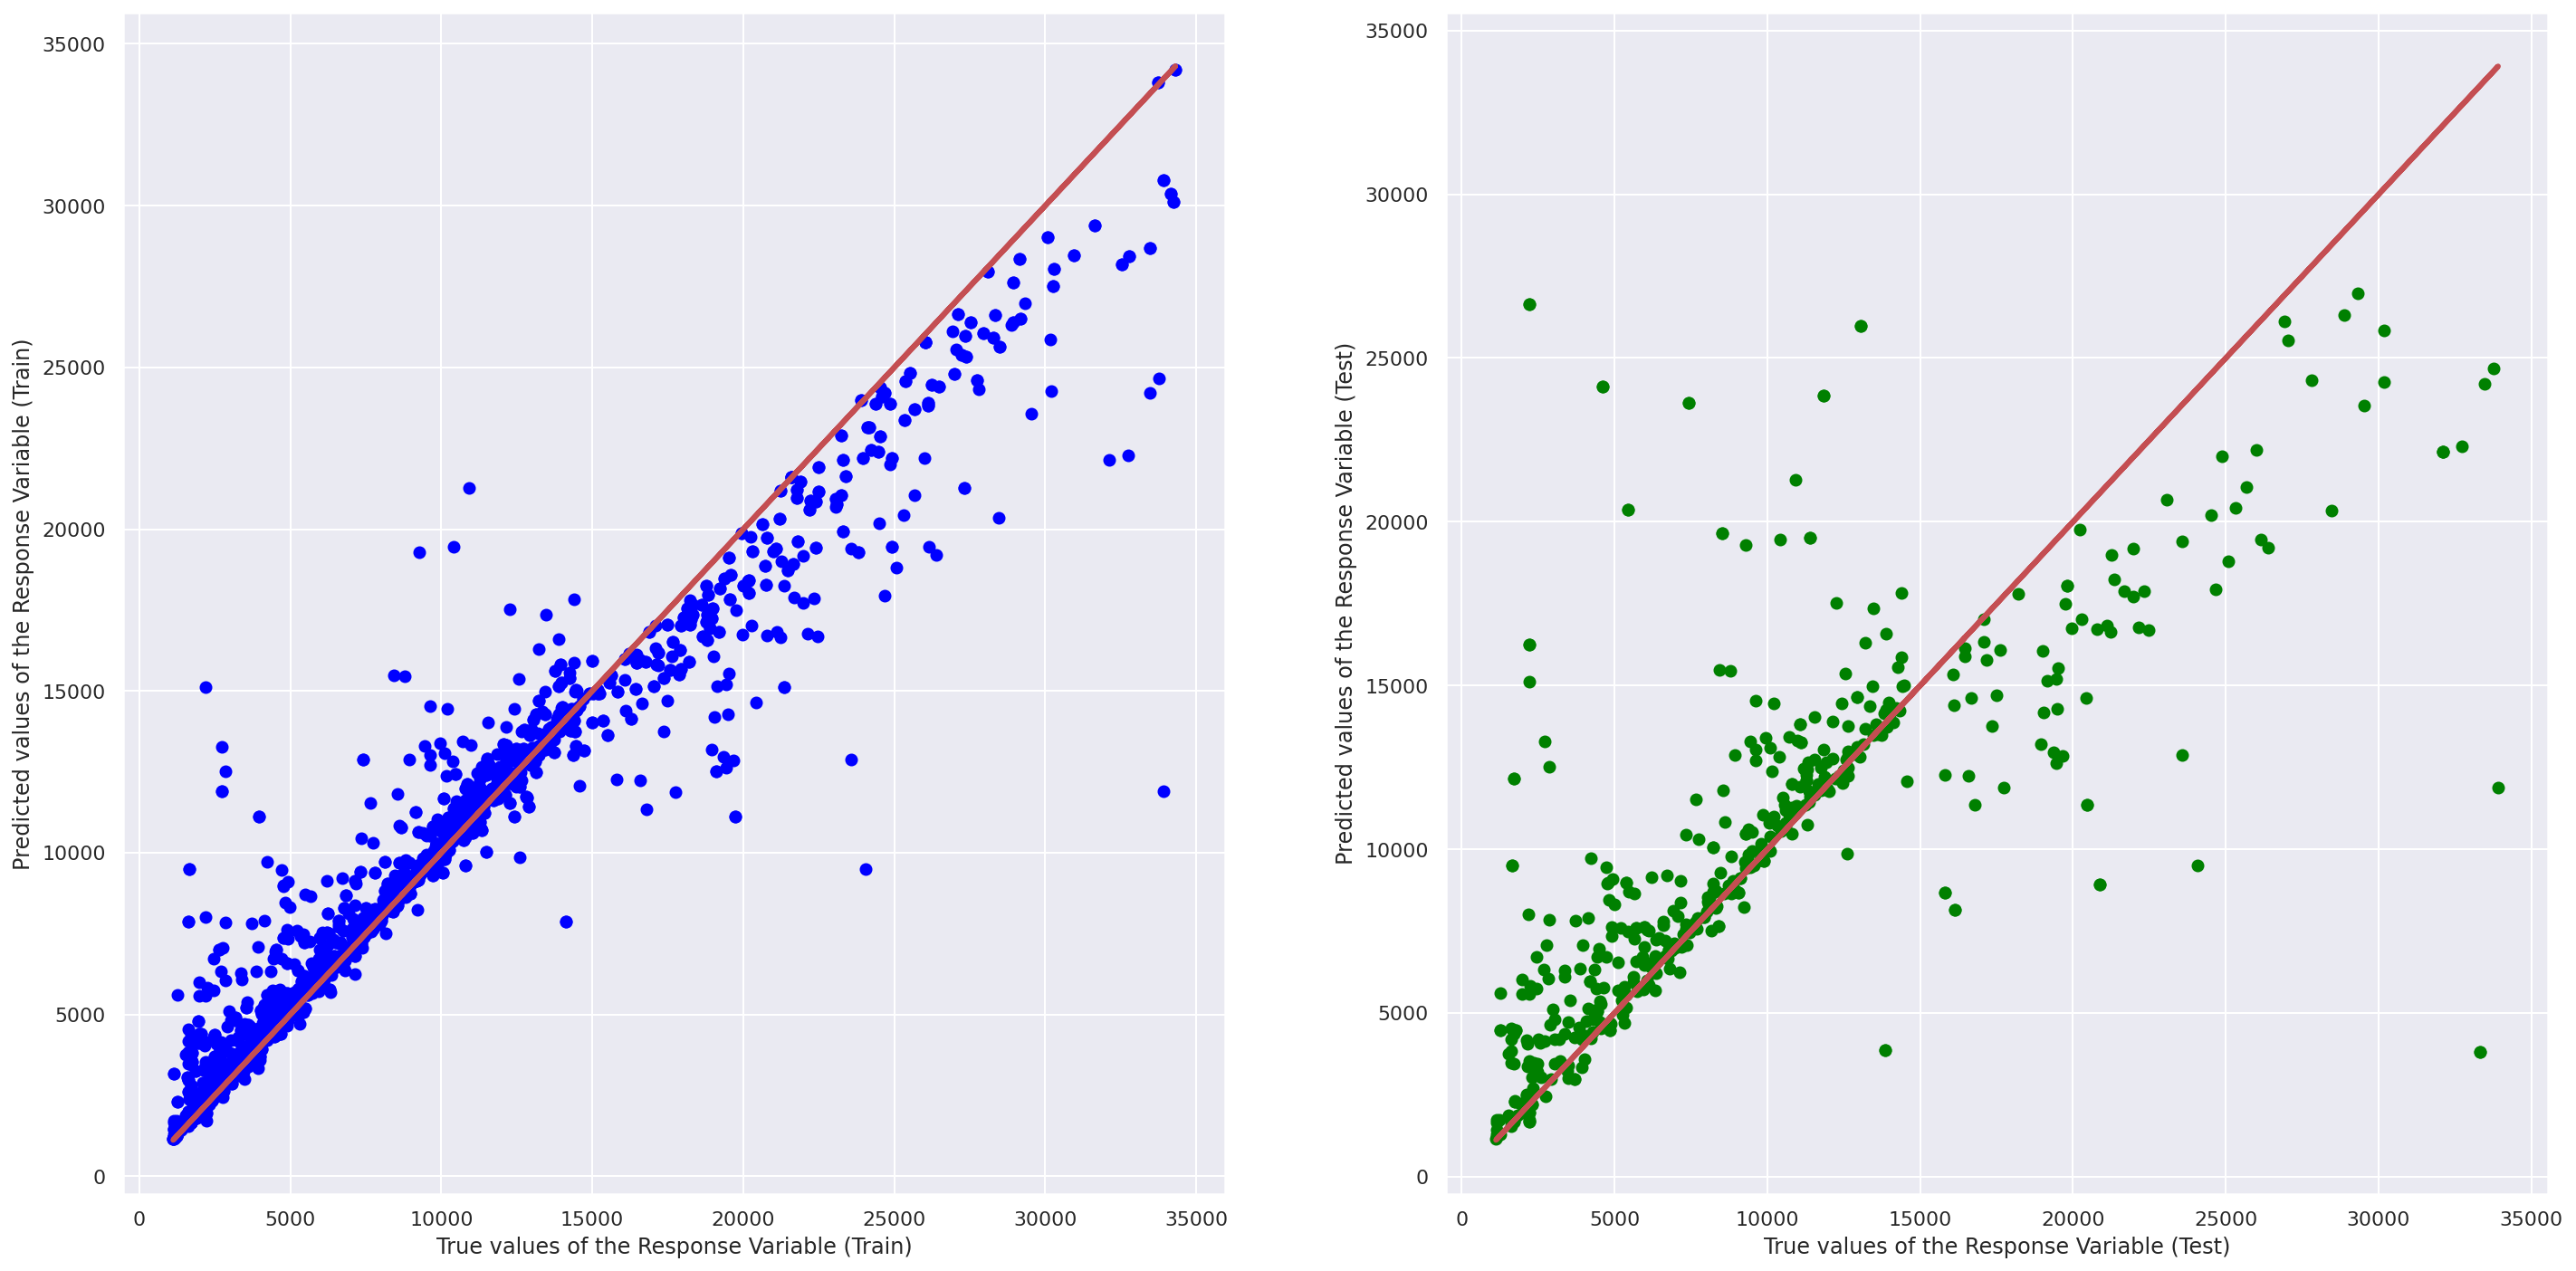

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have already split your data into X_train, X_test, y_train, and y_test

# Initialize the Random Forest Regressor with random_state set to 42 for reproducibility
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
random_forest_model.fit(X_train, y_train)

# Predict on the training set and the test set
y_train_pred_rf = random_forest_model.predict(X_train)
y_test_pred_rf = random_forest_model.predict(X_test)

# Calculate the mean squared error
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate the coefficient of determination (R^2)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print out the metrics
print(f'Train MSE: {mse_train_rf}')
print(f'Test MSE: {mse_test_rf}')
print(f'Train R^2: {r2_train_rf}')
print(f'Test R^2: {r2_test_rf}')

# Visualizing the results with scatter plots
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred_rf, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 3)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred_rf, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 3)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


### Logistic Regression

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the threshold for 'high' charges.
# For the sake of example, let's use the median value of charges as the threshold.
charges_threshold = medIn_cleaned_copy['charges'].median()

# Create a binary target variable based on the threshold
medIn_cleaned_copy['high_charges'] = (medIn_cleaned_copy['charges'] > charges_threshold).astype(int)

# Define the feature matrix and target vector
X = medIn_cleaned_copy[['smoker', 'sex']]  # 'smoker' and 'sex' are already in the correct binary format
y = medIn_cleaned_copy['high_charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.6169354838709677

Confusion Matrix:
[[252   0]
 [190  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       252
           1       1.00      0.22      0.36       244

    accuracy                           0.62       496
   macro avg       0.79      0.61      0.54       496
weighted avg       0.78      0.62      0.55       496



In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the threshold for 'high' charges.
# Define the threshold for 'high' charges as the 75th percentile of the 'charges' distribution
charges_threshold = medIn_cleaned_copy['charges'].quantile(0.75)

# Create a binary target variable based on the threshold
medIn_cleaned_copy['high_charges'] = (medIn_cleaned_copy['charges'] > charges_threshold).astype(int)

# Define the feature matrix and target vector
X = medIn_cleaned_copy[['smoker', 'sex']]  # 'smoker' and 'sex' are already in the correct binary format
y = medIn_cleaned_copy['high_charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.875

Confusion Matrix:
[[380   0]
 [ 62  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       380
           1       1.00      0.47      0.64       116

    accuracy                           0.88       496
   macro avg       0.93      0.73      0.78       496
weighted avg       0.89      0.88      0.86       496



In [152]:
print(charges_threshold)

12829.4551


<span style='font-size:medium'>**class 0: Below Threshold**</span>

- <span style='font-size:medium'>Precision is 0.86. This means that among all instances predicted as class 0, 86% were actually class 0.</span>
- <span style='font-size:medium'>Recall is 1.00. This means that among all instances that are actually class 0, the model correctly identified 100% of them.</span>
- <span style='font-size:medium'>F1\-score is 0.92, which is the harmonic mean of precision and recall for class 0.0.</span>

<span style='font-size:medium'>**class 1: Above Threshold**</span><span style='font-size:medium'> </span>

- <span style='font-size:medium'>Precision is 1.00. This means that among all instances predicted as class 1, 100% were actually class 1.</span>

- <span style='font-size:medium'>Recall is 0.47. This means that among all instances that are actually class 1, the model correctly identified 47% of them.</span>

- <span style='font-size:medium'>F1\-score is 0.64, which is the harmonic mean of precision and recall for class 1.</span>

<span style='font-size:medium'>Accuracy: The </span><span style='font-size:medium'>**overall accuracy of model is 0.875 \(3 d.p.\)**</span><span style='font-size:medium'>, meaning that approximately 87.50% of predictions are correct.</span>

<span style='font-size:medium'>Support: Indicates the number of instances for each class in the test data.</span>

<span style='font-size:medium'>**Confusion Matrix:**</span>

- <span style='font-size:medium'>True Negative \(TN\): 380 instances were correctly predicted as class 0.0.</span>

- <span style='font-size:medium'>False Positive \(FP\): 0 instances were incorrectly predicted as class 1.0.</span>

- <span style='font-size:medium'>False Negative \(FN\): 62 instances were incorrectly predicted as class 0.0.</span>

- <span style='font-size:medium'>True Positive \(TP\): 54 instances were correctly predicted as class 1.0</span>

<span style='font-size:medium'>**Prediction Rates:**</span>

- <span style='font-size:medium'>True Positive Rate \(TPR\): 0.46551724</span>
- <span style='font-size:medium'>False Positive Rate \(FPR\): 0</span>

<span style='font-size:medium'>TPR is moderately high, and FPR is 0, which is low.</span>

<span style='font-size:medium'>Overall, performance of model is moderately high, with high precision for class 1 \(above threshold\) and high recall for class 0 \(below threshold\). However, the recall for class 1 is observably lower, suggesting that the model may struggle to correctly predict insurance above the 0.75 threshold \(12829.4551\).</span>  



#### ---Ive edited up to here -----



<span style='font-size:x-large'>**Classification Tree**</span>  



In [0]:
reason_dta = pd.DataFrame(flight_data_clean['ORIGIN_AIRPORT'])  # Predictor
delay_dta = pd.DataFrame(flight_data_clean['DELAY'])  # Response

In [0]:
rdm_state_value = 42 #may need to trial and error
x_train, x_test, y_train, y_test = train_test_split(reason_dta, delay_dta, test_size = 0.25, random_state=rdm_state_value)


In [0]:
dectree = DecisionTreeClassifier(max_depth = 3)
dectree.fit(x_train, y_train)

f = plt.figure(figsize=(16,16))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=["Flight Number"], 
          class_names=["No delay","Delay"])

In [0]:
# Predict delay or not corresponding to fli_dta
y_train_pred = dectree.predict(x_train)
y_test_pred = dectree.predict(x_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(x_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(x_test, y_test))
print()

## ForestTree Classification



In [0]:
rdm_state_value = 42 #may need to trial and error
data = pd.DataFrame({'DAYOFWEEK':flight_data_clean['DAYOFWEEK'],'DELAY':flight_data_clean['DELAY']}) 

x = pd.DataFrame(flight_data_clean['DAYOFWEEK'])
y=  pd.DataFrame(flight_data_clean['DELAY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=rdm_state_value)


In [0]:
print(data.head())

In [0]:
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
from sklearn import metrics  
print()
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [0]:
data= pd.DataFrame({'SCHEDULED_DEPARTURE':flight_data_clean['SCHEDULED_DEPARTURE'],'DELAY':flight_data_clean['DELAY']}) 

x = pd.DataFrame(flight_data_clean['SCHEDULED_DEPARTURE'])
y=  pd.DataFrame(flight_data_clean['DELAY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=rdm_state_value)


In [0]:
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
from sklearn import metrics  
print()
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [0]:
data= pd.DataFrame({'DISTANCE':flight_data_clean['DISTANCE'],'DELAY':flight_data_clean['DELAY']}) 

x = pd.DataFrame(flight_data_clean['DISTANCE'])
y=  pd.DataFrame(flight_data_clean['DELAY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=rdm_state_value)

clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
from sklearn import metrics  
print()
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [0]:
data= pd.DataFrame({'AIRPORT_CODE':flight_data_clean['AIRPORT_CODE'],'DELAY':flight_data_clean['DELAY']}) 

x = pd.DataFrame(flight_data_clean['AIRPORT_CODE'])
y=  pd.DataFrame(flight_data_clean['DELAY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=rdm_state_value)

clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
from sklearn import metrics  
print()
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [0]:
data = pd.DataFrame({'DAYOFWEEK':flight_data_clean['DAYOFWEEK'],'SCHEDULED_DEPARTURE':flight_data_clean['SCHEDULED_DEPARTURE'],'DISTANCE':flight_data_clean['DISTANCE'], 'AIRPORT_CODE':flight_data_clean['AIRPORT_CODE'], 'DELAY':flight_data_clean['DELAY']}) 

x = pd.DataFrame(flight_data_clean[['DAYOFWEEK', 'SCHEDULED_DEPARTURE', 'DISTANCE', 'AIRPORT_CODE']])
y=  pd.DataFrame(flight_data_clean['DELAY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=rdm_state_value)

clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train, y_train.values.ravel())
y_pred = clf.predict(x_test)
from sklearn import metrics  
print()
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))